In [2]:
from google.colab import files
import pandas as pd

# Upload the file
uploaded = files.upload()

# Load CSV into DataFrame
df = pd.read_csv("updated_u2714523_DS7010_Credit.csv")
df.head()


Saving updated_u2714523_DS7010_Credit.csv to updated_u2714523_DS7010_Credit.csv


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,160000,2,2,2,33,2,2,3,2,0,...,164310,162681,163005,15000,0,0,6100,12300,6100,0
1,150000,2,1,2,34,1,-1,-1,-2,-2,...,0,0,0,53,0,0,0,0,0,0
2,10000,1,2,1,50,1,2,0,0,0,...,8067,8227,8400,2,1281,1134,294,305,1000,0
3,220000,2,1,2,29,0,0,0,0,0,...,218513,131660,134346,9100,9000,7887,4800,4900,6000,1
4,310000,2,1,2,32,1,-2,-1,0,0,...,326,-235,-235,0,326,0,0,0,1200,0


In [3]:
from sklearn.preprocessing import MinMaxScaler

# Target variable
target = 'default payment next month'

# Separate features and target
X = df.drop(columns=[target])
y = df[target]

# Apply Min-Max Scaling
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


In [5]:
from sklearn.ensemble import RandomForestClassifier

# Initial RF model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

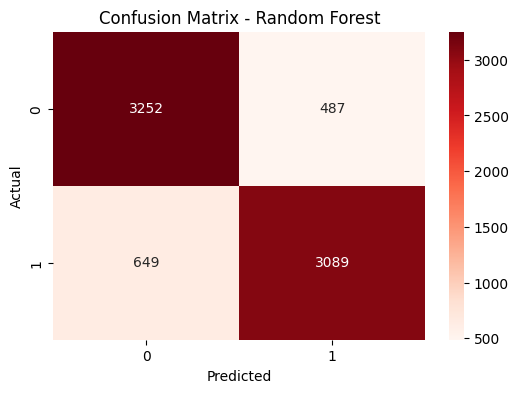

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      3739
           1       0.86      0.83      0.84      3738

    accuracy                           0.85      7477
   macro avg       0.85      0.85      0.85      7477
weighted avg       0.85      0.85      0.85      7477



In [6]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred = rf.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred))


In [7]:
from sklearn.model_selection import GridSearchCV


In [8]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


In [9]:
# Base Random Forest
rf = RandomForestClassifier(random_state=42)

# GridSearch with 5-fold cross validation
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,   # Use all CPU cores
    verbose=2,
    scoring='accuracy'   # You can also use 'f1' or 'roc_auc'
)


In [10]:
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Best score
print("Best Cross-Validation Score:", grid_search.best_score_)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Cross-Validation Score: 0.8417321518140778


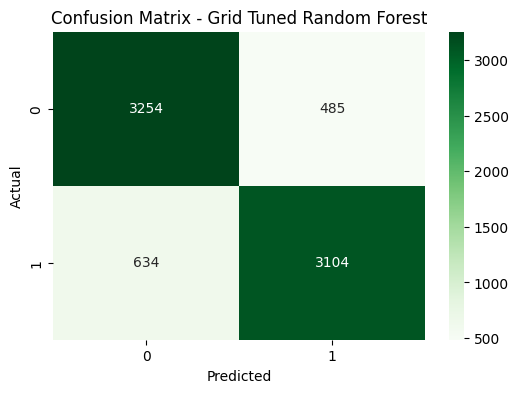

              precision    recall  f1-score   support

           0       0.84      0.87      0.85      3739
           1       0.86      0.83      0.85      3738

    accuracy                           0.85      7477
   macro avg       0.85      0.85      0.85      7477
weighted avg       0.85      0.85      0.85      7477



In [11]:
# Best model
best_rf = grid_search.best_estimator_

# Predict on test set
y_pred_tuned = best_rf.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tuned)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Grid Tuned Random Forest")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred_tuned))


In [12]:
# Check target distribution
print(y.value_counts(normalize=True))


default payment next month
0    0.5
1    0.5
Name: proportion, dtype: float64


In [13]:
from sklearn.ensemble import RandomForestClassifier

# Cost-sensitive Random Forest
cs_rf = RandomForestClassifier(
    random_state=42,
    class_weight='balanced',   # handles imbalance
    n_estimators=grid_search.best_params_['n_estimators'], # use tuned params if you want
    max_depth=grid_search.best_params_['max_depth'],
    min_samples_split=grid_search.best_params_['min_samples_split'],
    min_samples_leaf=grid_search.best_params_['min_samples_leaf']
)

cs_rf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=300,
                       random_state=42)

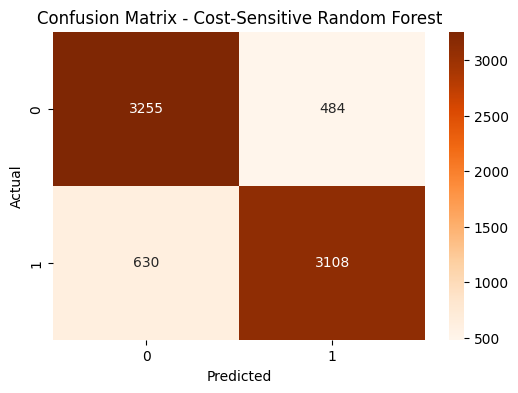

              precision    recall  f1-score   support

           0       0.84      0.87      0.85      3739
           1       0.87      0.83      0.85      3738

    accuracy                           0.85      7477
   macro avg       0.85      0.85      0.85      7477
weighted avg       0.85      0.85      0.85      7477



In [14]:
# Predictions
y_pred_cs = cs_rf.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_cs)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Cost-Sensitive Random Forest")
plt.show()

# Classification Report
print(classification_report(y_test, y_pred_cs))


In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Initial KNN with k=5 (default)
knn_initial = KNeighborsClassifier()
knn_initial.fit(X_train, y_train)

# Predictions
y_pred_knn_initial = knn_initial.predict(X_test)

print("Initial KNN Performance:")
print(classification_report(y_test, y_pred_knn_initial))


Initial KNN Performance:
              precision    recall  f1-score   support

           0       0.75      0.74      0.74      3739
           1       0.74      0.75      0.75      3738

    accuracy                           0.74      7477
   macro avg       0.74      0.74      0.74      7477
weighted avg       0.74      0.74      0.74      7477



In [16]:
from sklearn.model_selection import GridSearchCV

# Parameter grid
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# GridSearchCV
grid_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid_knn,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_knn.fit(X_train, y_train)

print("Best Params KNN:", grid_knn.best_params_)
print("Best CV Score:", grid_knn.best_score_)

# Best model
knn_tuned = grid_knn.best_estimator_
y_pred_knn_tuned = knn_tuned.predict(X_test)

print("Tuned KNN Performance:")
print(classification_report(y_test, y_pred_knn_tuned))


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Params KNN: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Best CV Score: 0.7797023909045311
Tuned KNN Performance:
              precision    recall  f1-score   support

           0       0.79      0.76      0.77      3739
           1       0.77      0.80      0.78      3738

    accuracy                           0.78      7477
   macro avg       0.78      0.78      0.78      7477
weighted avg       0.78      0.78      0.78      7477



In [18]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix

# Oversample minority class (default = 1)
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Original class distribution:")
print(y_train.value_counts())
print("\nResampled class distribution:")
print(y_train_res.value_counts())

# Train KNN on balanced data
knn_cs = KNeighborsClassifier(
    n_neighbors=grid_knn.best_params_['n_neighbors'],
    weights='distance',  # distance-based weighting
    metric=grid_knn.best_params_['metric']
)

knn_cs.fit(X_train_res, y_train_res)
y_pred_knn_cs = knn_cs.predict(X_test)

print("Cost-Sensitive KNN (via SMOTE) Performance:")
print(classification_report(y_test, y_pred_knn_cs))


Original class distribution:
default payment next month
1    14953
0    14952
Name: count, dtype: int64

Resampled class distribution:
default payment next month
1    14953
0    14953
Name: count, dtype: int64
Cost-Sensitive KNN (via SMOTE) Performance:
              precision    recall  f1-score   support

           0       0.79      0.76      0.77      3739
           1       0.77      0.80      0.78      3738

    accuracy                           0.78      7477
   macro avg       0.78      0.78      0.78      7477
weighted avg       0.78      0.78      0.78      7477



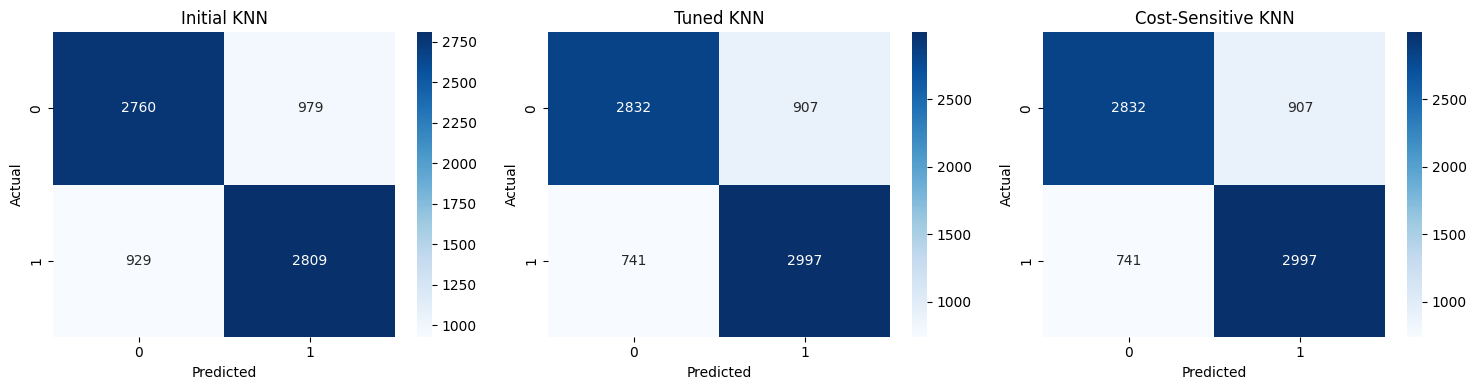

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

models = {
    "Initial KNN": y_pred_knn_initial,
    "Tuned KNN": y_pred_knn_tuned,
    "Cost-Sensitive KNN": y_pred_knn_cs
}

plt.figure(figsize=(15,4))

for i, (name, preds) in enumerate(models.items(), 1):
    cm = confusion_matrix(y_test, preds)
    plt.subplot(1, 3, i)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
    plt.title(name)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()


In [22]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_scaled, y)

print("Original distribution:\n", y.value_counts())
print("\nResampled distribution:\n", pd.Series(y_resampled).value_counts())


Original distribution:
 default payment next month
0    18691
1    18691
Name: count, dtype: int64

Resampled distribution:
 default payment next month
0    18691
1    18691
Name: count, dtype: int64


In [23]:
# Reattach target to resampled features
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled[target] = y_resampled

# Define selected columns
selected_columns = [
    "LIMIT_BAL", "SEX", "EDUCATION", "AGE",
    "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6",
    "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6",
    "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6",
    target
]

# Create new DataFrame with selected variables
df_selected = df_resampled[selected_columns]

df_selected.head()


,LIMIT_BAL,SEX,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,0.151515,1.0,0.333333,0.222222,0.4,0.4,0.5,0.4,0.2,0.2,...,0.252481,0.241957,0.386245,0.017171,0.000000,0.000000,0.009823,0.028837,0.011538,0
1,0.141414,1.0,0.166667,0.240741,0.3,0.1,0.1,0.0,0.0,0.0,...,0.083598,0.080648,0.260979,0.000061,0.000000,0.000000,0.000000,0.000000,0.000000,0
2,0.000000,0.0,0.333333,0.537037,0.3,0.4,0.2,0.2,0.2,0.2,...,0.091889,0.088806,0.267434,0.000002,0.001054,0.001266,0.000473,0.000715,0.001892,0
3,0.212121,1.0,0.166667,0.148148,0.2,0.2,0.2,0.2,0.2,0.2,...,0.308193,0.211198,0.364221,0.010417,0.007405,0.008802,0.007729,0.011488,0.011349,1
4,0.303030,1.0,0.166667,0.203704,0.3,0.0,0.1,0.2,0.2,0.0,...,0.083933,0.080415,0.260798,0.000000,0.000268,0.000000,0.000000,0.000000,0.002270,0


In [24]:
from sklearn.model_selection import train_test_split

X = df_selected.drop(target, axis=1)
y = df_selected[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


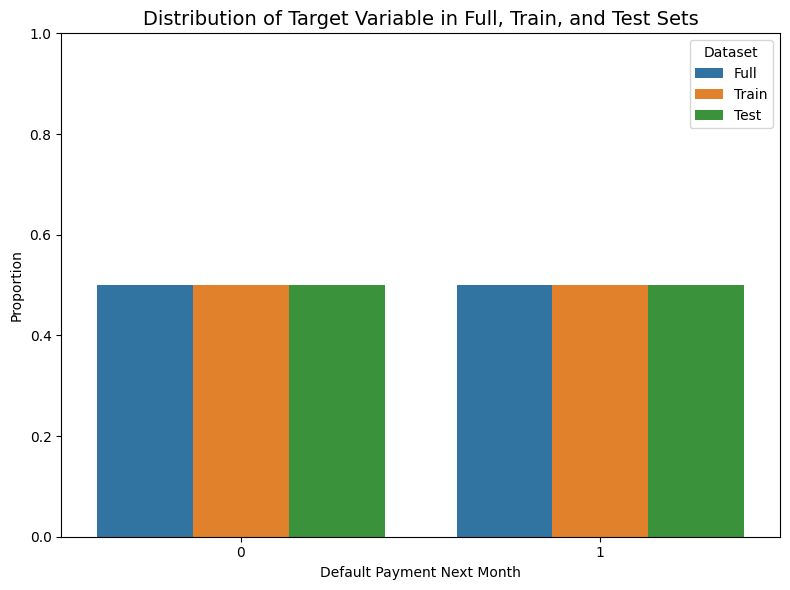

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Full distribution
df_full = y.value_counts(normalize=True).rename_axis("Class").reset_index(name="Proportion")
df_full["Dataset"] = "Full"

# Train distribution
df_train = y_train.value_counts(normalize=True).rename_axis("Class").reset_index(name="Proportion")
df_train["Dataset"] = "Train"

# Test distribution
df_test = y_test.value_counts(normalize=True).rename_axis("Class").reset_index(name="Proportion")
df_test["Dataset"] = "Test"

# Combine into single DataFrame
dist_df = pd.concat([df_full, df_train, df_test], ignore_index=True)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=dist_df, x="Class", y="Proportion", hue="Dataset")
plt.title("Distribution of Target Variable in Full, Train, and Test Sets", fontsize=14)
plt.ylabel("Proportion")
plt.xlabel("Default Payment Next Month")
plt.ylim(0, 1)
plt.legend(title="Dataset")
plt.tight_layout()
plt.show()


In [26]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [28]:
TARGET_COLUMN = 'default payment next month'

X = df_selected.drop(TARGET_COLUMN, axis=1)  # predictors
y = df_selected[TARGET_COLUMN]               # target


In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [30]:
# ----------------- Step 3: Random Forest pipeline -----------------
rf_pipeline = Pipeline([
    ('rf', RandomForestClassifier(random_state=42))
])

# Train Random Forest
rf_pipeline.fit(X_train, y_train)

# Predict and evaluate Random Forest
y_pred_rf = rf_pipeline.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.8459275110338371
Random Forest Confusion Matrix:
 [[3236  503]
 [ 649 3089]]
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85      3739
           1       0.86      0.83      0.84      3738

    accuracy                           0.85      7477
   macro avg       0.85      0.85      0.85      7477
weighted avg       0.85      0.85      0.85      7477



In [31]:
# ----------------- Step 4: KNN pipeline -----------------
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # KNN requires scaling
    ('knn', KNeighborsClassifier())
])

# Train KNN
knn_pipeline.fit(X_train, y_train)

# Predict and evaluate KNN
y_pred_knn = knn_pipeline.predict(X_test)
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("KNN Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
print("KNN Classification Report:\n", classification_report(y_test, y_pred_knn))

KNN Accuracy: 0.7527083054701084
KNN Confusion Matrix:
 [[2731 1008]
 [ 841 2897]]
KNN Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.73      0.75      3739
           1       0.74      0.78      0.76      3738

    accuracy                           0.75      7477
   macro avg       0.75      0.75      0.75      7477
weighted avg       0.75      0.75      0.75      7477

